# Data Wrangling & Baseline Model
---

#### Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# import nltk
from sklearn import *

In [2]:
import matplotlib.style as style 

style.use('seaborn-darkgrid')
sns.set_context('notebook')
sns.set_palette('gist_heat')

## Wrangling

In [3]:
os.listdir('./csv_folder')

['test.csv',
 'items.csv',
 'item_categories.csv',
 'sales_train.csv',
 'shops.csv']

- We will need to join the ***items*** and the ***sales_train*** dataframes
- The ***shops*** and ***item_categories*** only contain the names of id values
- The final file ***test*** will be used when submitting predictions

In [4]:
shops = pd.read_csv('./csv_folder/shops.csv')
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

The names of the shops are in russian, should find some encoding that is capable of handling these

In [5]:
item_categs = pd.read_csv('./csv_folder/item_categories.csv')
item_categs.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

As shown above, the ***shops*** and ***item_categories*** only contain the names of id values. These may be useful later but for now we will use only the id values.

In [6]:
test = pd.read_csv('./csv_folder/test.csv')
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

Showing the ***test*** data for reference

---
---  
### Understanding the sales_train data
---

In [7]:
train_df = pd.read_csv('./csv_folder/sales_train.csv', 
                      dtype={'shop_id':'int8', 
                            'item_id':'int16',
                            'item_cnt_month':'int32',
                            'date_block_num':'int8'})

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int8   
 2   shop_id         int8   
 3   item_id         int16  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int16(1), int8(2), object(1)
memory usage: 78.4+ MB


Lets break the date column into month and year, later we will aggregate item sales counts from days to months

In [9]:
train_df.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03

In [10]:
train_df['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int8)

***date_block_num***: a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

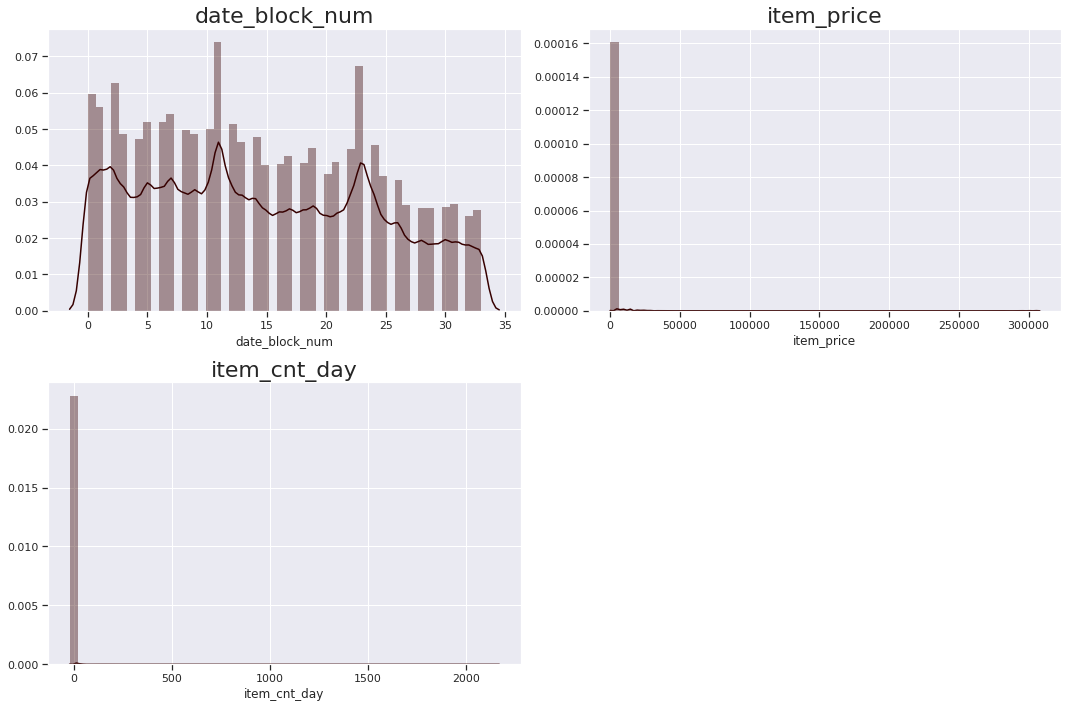

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.distplot(train_df['date_block_num'], ax=axes[0,0]).set_title('date_block_num', size=22)

sns.distplot(train_df['item_price'], ax=axes[0,1]).set_title('item_price', size=22)

sns.distplot(train_df['item_cnt_day'], ax=axes[1,0], kde_kws={'bw': 0.1}).set_title('item_cnt_day', size=22)

axes[1,1].set_visible(False)

plt.tight_layout()

In [12]:
train_df['item_cnt_day'].nunique()

198

In [13]:
train_df.index.nunique()

2935849

In [14]:
train_df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Dataframe contains no missing values

---
---  
### Understanding the items data
---

In [15]:
items = pd.read_csv('./csv_folder/items.csv')

In [16]:
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [17]:
items['item_category_id'].nunique()

84

There are 84 different categories for items

In [18]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

Dataframe contains no missing values

---
---  
### ????? Merging the sales train data frame with the items data 
---

***A pivot table to give a better visual understanding of the data***

In [19]:
train_df.pivot_table(index = ['shop_id','item_id'],
                     values = ['item_cnt_day'],
                     columns = ['date_block_num'],
                     fill_value = 0,
                     aggfunc='sum').head()

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  

[5 rows x 34 columns]

---  
***??? Agregating sales counts by month per store per item***  

In [20]:
train_df.drop(['item_price'], axis=1, inplace=True)

In [21]:
train_df['date'] = pd.to_datetime(train_df['date'], dayfirst=True)
train_df['year'] = train_df.date.dt.year
train_df['month'] = train_df.date.dt.month

key_df = train_df[['date_block_num', 'year', 'month']].groupby(['date_block_num', 'year', 'month']).count().reset_index().set_index(['year', 'month'])
key_df.sort_values('date_block_num', ascending=True, inplace=True)

Making a key to recover the date block number because the next step will remove this column 

In [22]:
####
# Writing to file for recovery to allow of a mid-notebook boot (incase there is insufficient ram)
####
# key_df.to_csv('wrangled_data/key_dateblock.csv', index=True)

In [23]:
train_df = train_df.groupby([c for c in train_df.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train_df = train_df.rename(columns={'item_cnt_day':'item_cnt_month'})

train_df = pd.DataFrame(train_df.groupby(['shop_id', 'item_id', 'year', 'month'])['item_cnt_month'].sum()).reset_index()

Aggregating the item sales count into months since that is the figure we are being asked to predict

In [24]:
train_df.head(2)

shop_id  item_id  year  month  item_cnt_month
0        0       30  2013      2            31.0
1        0       31  2013      2            11.0

---
---

---  
***Fill missing rows***  
Creating rows for items that have zero count sales at a store for a given month

In [25]:
shop_items = test[['shop_id', 'item_id']].values
year = train_df.year.unique()
month = train_df.month.unique()
dates = [(y, m) for y in year for m in month]

In [26]:
shop_items.size

428400

In [27]:
# test_index = test[['shop_id', 'item_id']].values

In [28]:
# test_index.size

In [29]:
# for item in test_index:
#     if item not in shop_items:
#         shop_items.append(item)

In [30]:
# shop_items.size

In [31]:
index = pd.DataFrame([(d[0], d[1], k[0], k[1]) for d in dates for k in shop_items], 
                     columns=['year', 'month', 'shop_id', 'item_id'])

In [32]:
index.sort_values(by=['shop_id', 'item_id', 'year', 'month']).head()

year  month  shop_id  item_id
237187   2013      1        2       30
22987    2013      2        2       30
665587   2013      3        2       30
879787   2013      4        2       30
1093987  2013      5        2       30

In [33]:
# train_df['date'] = pd.to_datetime(train_df[['year', 'month']].assign(DAY=1))
train_df = pd.merge(index, train_df, 
                    how='left', 
                    on=['shop_id', 'item_id', 'year', 'month'])

In [34]:
del index

In [35]:
train_df.drop_duplicates(inplace=True)

In [36]:
train_df.isna().sum()

year                    0
month                   0
shop_id                 0
item_id                 0
item_cnt_month    7111041
dtype: int64

In [37]:
train_df['item_cnt_month'].fillna(0, inplace=True)

In [38]:
train_df.isna().sum()

year              0
month             0
shop_id           0
item_id           0
item_cnt_month    0
dtype: int64

---
---

In [39]:
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [40]:
train_df = pd.merge(test, train_df, on = ['item_id','shop_id'], how='left')

In [41]:
train_df.isna().sum()

ID                0
shop_id           0
item_id           0
year              0
month             0
item_cnt_month    0
dtype: int64

In [42]:
train_df.head()

ID  shop_id  item_id  year  month  item_cnt_month
0   0        5     5037  2013      2             0.0
1   0        5     5037  2013      1             0.0
2   0        5     5037  2013      6             0.0
3   0        5     5037  2013      3             0.0
4   0        5     5037  2013      4             0.0

---  
---  

In [43]:
# tmp = pd.DataFrame(train_df.groupby(['shop_id', 'item_id'])['item_cnt_month'].apply(lambda c: c.abs().sum()))

In [44]:
# train_df.set_index(['shop_id', 'item_id'], inplace=True)

In [45]:
# train_df = train_df.loc[tmp[tmp['item_cnt_month'] != 0].index]
# del tmp

In [46]:
# train_df.reset_index(inplace=True)

---  
---  

In [47]:
train_df = pd.merge(train_df, key_df, how='left', on=['year', 'month'])

In [48]:
train_df = train_df[~train_df['date_block_num'].isna()]

### Some Feature Engineering
---  

***Mean & Mode feature for items per store***

In [50]:
# Find mean sales for item at a store
agg_shop_item = pd.DataFrame(train_df[['shop_id', 'item_id', 'item_cnt_month']].groupby(['shop_id', 'item_id'], as_index=False).agg([np.mean, pd.Series.mode]))
agg_shop_item.columns = agg_shop_item.columns.droplevel()
agg_shop_item = agg_shop_item.rename(columns={'mean':'mean_item', 'mode':'mode_item'})

# Add mode to training set
train_df = pd.merge(train_df, agg_shop_item, how='left', on=['shop_id','item_id'])

Creating a feature for the mean of item sales count of each month 

In [51]:
# Add all item features
train_df = pd.merge(train_df, items.drop(columns=['item_category_id']), how='left', on='item_id')

Merging the items dataframe into the our current training dataframe 

In [52]:
train_df = pd.merge(train_df, items.drop(columns=['item_name']), how='left', on='item_id')
train_df.head()

ID  shop_id  item_id  year  month  item_cnt_month  date_block_num  \
0   0        5     5037  2013      2             0.0             1.0   
1   0        5     5037  2013      1             0.0             0.0   
2   0        5     5037  2013      6             0.0             5.0   
3   0        5     5037  2013      3             0.0             2.0   
4   0        5     5037  2013      4             0.0             3.0   

   mean_item mode_item                       item_name  item_category_id  
0   0.382353         0  NHL 15 [PS3, русские субтитры]                19  
1   0.382353         0  NHL 15 [PS3, русские субтитры]                19  
2   0.382353         0  NHL 15 [PS3, русские субтитры]                19  
3   0.382353         0  NHL 15 [PS3, русские субтитры]                19  
4   0.382353         0  NHL 15 [PS3, русские субтитры]                19

In [53]:
# Adding item category features
train_df = pd.merge(train_df, item_categs, how='left', on='item_category_id')

Merging the item cetegory dataframe into the our current training dataframe 

In [54]:
# Adding shop feature
train_df = pd.merge(train_df, shops, how='left', on='shop_id')

Merging the shops dataframe into the our current training dataframe 

In [55]:
train_df.head(2)

ID  shop_id  item_id  year  month  item_cnt_month  date_block_num  \
0   0        5     5037  2013      2             0.0             1.0   
1   0        5     5037  2013      1             0.0             0.0   

   mean_item mode_item                       item_name  item_category_id  \
0   0.382353         0  NHL 15 [PS3, русские субтитры]                19   
1   0.382353         0  NHL 15 [PS3, русские субтитры]                19   

  item_category_name               shop_name  
0         Игры - PS3  Вологда ТРЦ "Мармелад"  
1         Игры - PS3  Вологда ТРЦ "Мармелад"

The resulting training data after the merge

In [56]:
test['month']=11
test['year']=2015
test['date_block_num']=34

Adding the prediction value to testing data

In [57]:
# Adding mean feature
test = pd.merge(test, agg_shop_item, how='left', on=['shop_id', 'item_id']).fillna(0.)
# Add all item features
test = pd.merge(test, items, how='left', on='item_id')
# Adding item category features
test = pd.merge(test, item_categs, how='left', on='item_category_id')
# Adding shop feature
test = pd.merge(test, shops, how='left', on='shop_id')

Takes the same features we created for the training data and adds them to our teting data

In [58]:
test['item_cnt_month']=0.

---  

In [59]:
####
# Turns mode from series to float for training data
####
tmp = train_df['mode_item'].copy()
tri = pd.DataFrame([np.mean(i) for i in tmp])
train_df['mode_item'] = tri

train_df['mode_item'][train_df[train_df['mode_item'].isna()].index] = train_df['mean_item'][train_df[train_df['mode_item'].isna()].index]

####
# Turns mode from series to float for test data
####
tmp = test['mode_item'].copy()
tri = pd.DataFrame([np.mean(i) for i in tmp])
test['mode_item'] = tri

test['mode_item'][test[test['mode_item'].isna()].index] = test['mean_item'][test[test['mode_item'].isna()].index]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


---  
---  
#### ????? Load from saved csv

In [60]:
# key_df = pd.read_csv('wrangled_data/key_dateblock.csv')

####
# Writing to file for recovery to allow of a mid-notebook boot (incase there is insufficient ram)
####
# train_df.to_csv('wrangled_data/train_compress_index.csv', index=False)
# test.to_csv('wrangled_data/test_index.csv', index=False)

######
# test = pd.read_csv('wrangled_data/test_index.csv')
# train_df = pd.read_csv('wrangled_data/train_compress_index.csv', 
#                        dtype={'shop_id':'int8', 
#                             'item_id':'int16',
#                             'year':'int16',
#                             'month':'int8',
#                             'item_cnt_month':'int32',
#                             'date_block_num':'int8',
#                             'mean_item':'float64',
#                             'mode_item':'float64'})

---  
***Some label encoding for the names of items***  
May want to write csv before this and do further encoding in the preprocessing notebook  

In [61]:
# Label encoding
for c in ['shop_name', 'item_name', 'item_category_name']:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[c].unique())+list(test[c].unique()))
    train_df[c]=lbl.transform(train_df[c].astype(str))
    test[c]=lbl.transform(test[c].astype(str))
    print(c)

shop_name
item_name
item_category_name


---  
---  
### Building a baseline model using Extra Trees Regressor from sci-kit learn

In [62]:
# Train and predict using random forest 
col = [c for c in train_df.columns if c not in ['item_cnt_month']]
x1 = train_df[train_df['date_block_num']<33]
y1 = np.log1p(x1['item_cnt_month'].clip(0.,20.))
x1 = x1[col]
x2 = train_df[train_df['date_block_num'] == 33]
y2 = np.log1p(x2['item_cnt_month'].clip(0, 20.))
x2 = x2[col]

Creating a method to test our model without having to submit by using the most resent month as a hypothetical future month and then using the values of that month to validate the effectivness of the model

In [63]:
reg = ensemble.ExtraTreesRegressor(n_estimators=30, n_jobs=-1, max_depth=20, random_state=18)
reg.fit(x1,y1)
print('RMSE value is :', np.sqrt(metrics.mean_squared_error(y2.clip(0., 20.), reg.predict(x2).clip(0., 20.))))

RMSE value is : 0.2992458025426295


Since the competition grades models based upon the RMSE metric we will use that to evaluate our model so that we are optimizing in that direction

In [64]:
reg.fit(train_df[col], train_df['item_cnt_month'].clip(0., 20.))
test['item_cnt_month'] = reg.predict(test[col]).clip(0., 20.)

In [65]:
test[['ID', 'item_cnt_month']].to_csv('submission_files/submit.csv', index=False)

Writing the predictions to a csv file

---  
***Writing training and testing data into csv files***

In [69]:
test.drop(columns=['item_cnt_month']).to_csv('wrangled_data/testing_post_wrangle_small.csv', index=False)
train_df.to_csv('wrangled_data/training_post_wrangle_small.csv', index=False)

In [70]:
test.size

2784600

In [71]:
test.head()

ID  shop_id  item_id  month  year  date_block_num  mean_item  mode_item  \
0   0        5     5037     11  2015              34   0.382353        0.0   
1   1        5     5320     11  2015              34   0.000000        0.0   
2   2        5     5233     11  2015              34   0.294118        0.0   
3   3        5     5232     11  2015              34   0.029412        0.0   
4   4        5     5268     11  2015              34   0.000000        0.0   

   item_name  item_category_id  item_category_name  shop_name  item_cnt_month  
0       1195                19                  11          3    5.523605e-01  
1       1254                55                  39          3    2.107171e-06  
2       1239                19                  11          3    5.516304e-01  
3       1238                23                  15          3    2.096406e-01  
4       1245                20                  12          3    1.805393e-07

In [74]:
test.drop_duplicates().shape

(214200, 13)